In [1]:
import numpy as np
import pandas as pd
import pickle
import torch.nn as nn
from torch.utils.data import DataLoader
import json, ast, sys, csv, random
import plotly.express as px
import math
import datetime
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
class BaoTrainingException(Exception):
    pass
csv.field_size_limit(sys.maxsize)
from matplotlib import rcParams
plt.rcParams.update({'font.size': 13})

In [2]:
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Verdana']

# OPTIMIZADORES

In [3]:
model_adam = "Model_Adam"
model_agradad = "Model_Adagrad"
model_sgd = "Model_SGD"

In [4]:
def open_files(model):
    model_train_file = open('train_stats_'+model+'.json')
    model_train = ast.literal_eval(model_train_file.read())
    model_val_file = open('val_stats_'+model+'.json')
    model_val = ast.literal_eval(model_val_file.read())
    model_test_file = open('test_stats_'+model+'.json')
    model_test = ast.literal_eval(model_test_file.read())
    model_train_file.close()
    model_val_file.close()
    model_test_file.close()
    return model_train, model_val, model_test

In [5]:
def tag_points(x):
    """Add quality tags of predictions. Used to plot with plotly"""
    difference = x['time'] - x['y_pred'][0]
    abs_diff = np.abs(difference)
    x['y_pred'] = x['y_pred'][0]
    x['query2'] = x['query'].replace(" . ", ' . <br>').replace(" FILTER", '<br> FILTER').replace(" { ", ' { <br>').replace(" } ", ' <br> }').replace(" ; ", ' ; <br>') 
    p20 = x['time'] * 0.2
    p40 = x['time'] * 0.4
    if abs_diff < p20:
        x['color'] = "good prediction"
    elif abs_diff < p40:
        x['color'] = "aceptable prediction"
    else:
        x['color'] = "bad prediction"
    return x

In [6]:
def prediccion_list(model):
    good_p, good_r = [], []
    acceptable_p, acceptable_r = [], []
    bad_p, bad_r = [], []
    for p in range(len(model['pred'])):
        #print(model['pred'][p],model['real'][p])
        difference = model['pred'][p] - model['real'][p]
        abs_diff = np.abs(difference)
        p20 = model['real'][p] * 0.2
        p40 = model['real'][p] * 0.4
        if abs_diff < p20:
            good_r.append(model['real'][p])
            good_p.append(model['pred'][p])
        elif abs_diff < p40:
            acceptable_r.append(model['real'][p])
            acceptable_p.append(model['pred'][p])
        else:
            bad_r.append(model['real'][p])
            bad_p.append(model['pred'][p])
    return good_p, good_r, acceptable_p, acceptable_r, bad_p, bad_r
    

In [7]:
def prediccion_list2(model,tol1,tol2):
    good_p, good_r = [], []
    acceptable_p, acceptable_r = [], []
    bad_p, bad_r = [], []
    for p in range(len(model['pred'])):
        #print(model['pred'][p],model['real'][p])
        percent = (model['pred'][p]/model['real'][p]) * 100
        abs_diff = np.abs(100 - percent)
        if abs_diff < tol1:
            good_r.append(model['real'][p])
            good_p.append(model['pred'][p])
        elif abs_diff >= tol1 and abs_diff < tol2:
            acceptable_r.append(model['real'][p])
            acceptable_p.append(model['pred'][p])
        else:
            bad_r.append(model['real'][p])
            bad_p.append(model['pred'][p])
    return good_p, good_r, acceptable_p, acceptable_r, bad_p, bad_r

In [8]:
model_adam_train, model_adam_val, model_adam_test =  open_files(model_adam)
model_agradad_train, model_agradad_val, model_agradad_test =  open_files(model_agradad)
model_sgd_train, model_sgd_val, model_sgd_test =  open_files(model_sgd)

In [9]:
num_iter = len(model_adam_train['history']['mae_val_by_epoch'])

In [10]:
#num_iter = min([
#    len(model_adam_train['history']['rmse_val_by_epoch']),
#    len(model_agradad_train['history']['rmse_val_by_epoch']),
#    len(model_sgd_train['history']['rmse_val_by_epoch']),    
#])

In [11]:
#model_adam_train['history']['rmse_by_epoch'] = model_adam_train['history']['rmse_by_epoch'][0:num_iter]
#model_agradad_train['history']['rmse_by_epoch'] =model_agradad_train['history']['rmse_by_epoch'][0:num_iter]
#model_sgd_train['history']['rmse_by_epoch'] = model_sgd_train['history']['rmse_by_epoch'][0:num_iter]

#model_adam_train['history']['rmse_val_by_epoch'] = model_adam_train['history']['rmse_val_by_epoch'][0:num_iter]
#model_agradad_train['history']['rmse_val_by_epoch'] =model_agradad_train['history']['rmse_val_by_epoch'][0:num_iter]
#model_sgd_train['history']['rmse_val_by_epoch'] = model_sgd_train['history']['rmse_val_by_epoch'][0:num_iter]

#model_adam_train['history']['mae_by_epoch'] = model_adam_train['history']['mae_by_epoch'][0:num_iter]
#model_agradad_train['history']['mae_by_epoch'] =model_agradad_train['history']['mae_by_epoch'][0:num_iter]
#model_sgd_train['history']['mae_by_epoch'] = model_sgd_train['history']['mae_by_epoch'][0:num_iter]

#model_adam_train['history']['mae_val_by_epoch'] = model_adam_train['history']['mae_val_by_epoch'][0:num_iter]
#model_agradad_train['history']['mae_val_by_epoch'] =model_agradad_train['history']['mae_val_by_epoch'][0:num_iter]
#model_sgd_train['history']['mae_val_by_epoch'] = model_sgd_train['history']['mae_val_by_epoch'][0:num_iter]

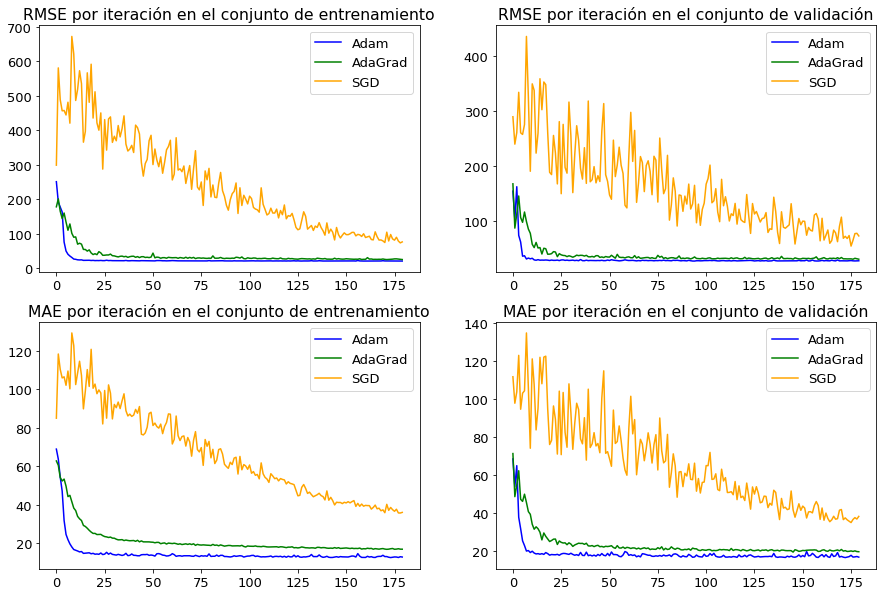

In [12]:
# Some example data to display

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
#fig.suptitle('RMSE por iteración')
c = ['green','blue','yellow','orange','grey','black']
index = np.arange(num_iter)
ax1.set_title('RMSE por iteración en el conjunto de entrenamiento')
ax1.plot(index, model_adam_train['history']['rmse_by_epoch'], color=c[1], label='Adam')
ax1.plot(index, model_agradad_train['history']['rmse_by_epoch'], color=c[0], label='AdaGrad')
ax1.plot(index, model_sgd_train['history']['rmse_by_epoch'], color=c[3], label='SGD')
ax1.legend()

ax2.set_title('RMSE por iteración en el conjunto de validación')
ax2.plot(index, model_adam_train['history']['rmse_val_by_epoch'], color=c[1], label='Adam')
ax2.plot(index, model_agradad_train['history']['rmse_val_by_epoch'], color=c[0], label='AdaGrad')
ax2.plot(index, model_sgd_train['history']['rmse_val_by_epoch'], color=c[3], label='SGD')
ax2.legend()

ax3.set_title('MAE por iteración en el conjunto de entrenamiento')
ax3.plot(index, model_adam_train['history']['mae_by_epoch'], color=c[1], label='Adam')
ax3.plot(index, model_agradad_train['history']['mae_by_epoch'], color=c[0], label='AdaGrad')
ax3.plot(index, model_sgd_train['history']['mae_by_epoch'], color=c[3], label='SGD')
ax3.legend()

ax4.set_title('MAE por iteración en el conjunto de validación')
ax4.plot(index, model_adam_train['history']['mae_val_by_epoch'], color=c[1], label='Adam')
ax4.plot(index, model_agradad_train['history']['mae_val_by_epoch'], color=c[0], label='AdaGrad')
ax4.plot(index, model_sgd_train['history']['mae_val_by_epoch'], color=c[3], label='SGD')
ax4.legend()
plt.savefig("RMSE_MAE_optimizadores.pdf")

# set labels

In [13]:
model_adam_val['pred']

[14.758463859558105,
 1.6255521774291992,
 14.758463859558105,
 14.758463859558105,
 42.48406982421875,
 49.54902267456055,
 36.944313049316406,
 13.64535903930664,
 14.758463859558105,
 28.227203369140625,
 1.5922574996948242,
 10.707067489624023,
 14.758463859558105,
 1.6895112991333008,
 49.392757415771484,
 1.6255521774291992,
 1.5922574996948242,
 14.758463859558105,
 2.1395480632781982,
 14.758463859558105,
 1.6895112991333008,
 62.53260040283203,
 14.758463859558105,
 4.89743709564209,
 1.724024772644043,
 1.5922574996948242,
 1.9915330410003662,
 43.36328887939453,
 3.685208320617676,
 1.5937821865081787,
 14.758463859558105,
 3.3835043907165527,
 1.5937821865081787,
 1.7352204322814941,
 2.3025102615356445,
 1.9224987030029297,
 3.1288342475891113,
 14.758463859558105,
 14.758463859558105,
 2.1534957885742188,
 14.758463859558105,
 2.5300354957580566,
 1.7352204322814941,
 1.6895112991333008,
 49.392757415771484,
 14.758463859558105,
 14.758463859558105,
 46.754459381103516,
 

In [14]:
model_adam_train.keys()

dict_keys(['pred', 'real', 'mse', 'mae', 'rmse', 'history'])

In [15]:
adam_split_train = prediccion_list(model_adam_train)
agradad_split_train = prediccion_list(model_agradad_train)
sgd_split_train = prediccion_list(model_sgd_train)

adam_split_val = prediccion_list(model_adam_val)
agradad_split_val = prediccion_list(model_agradad_val)
sgd_split_val = prediccion_list(model_sgd_val)

# LEARNING RATES

In [16]:
model_adam_0_0000015 = "Model_Adam_0.0000015"
model_adam_0_000015 = "Model_Adam_0.000015"
model_adam_0_00015 = "Model_Adam"
model_adam_0_0015 = "Model_Adam_0.0015"

In [17]:
model_adam_0_0000015_train, model_adam_0_0000015_val, model_adam_0_0000015_test =  open_files(model_adam_0_0000015)
model_adam_0_000015_train, model_adam_0_000015_val, model_adam_0_000015_test =  open_files(model_adam_0_000015)
model_adam_0_00015_train, model_adam_0_00015_val, model_adam_0_00015_test =  open_files(model_adam_0_00015)
model_adam_0_0015_train, model_adam_0_0015_val, model_adam_0_0015_test =  open_files(model_adam_0_0015)

In [18]:
num_iter = min([
    len(model_adam_0_0000015_train['history']['rmse_val_by_epoch']),
    len(model_adam_0_000015_train['history']['rmse_val_by_epoch']),
    len(model_adam_0_00015_train['history']['rmse_val_by_epoch']),    
    len(model_adam_0_0015_train['history']['rmse_val_by_epoch']),    
])

In [19]:
#model_adam_0_0000015_train['history']['rmse_by_epoch'] = model_adam_0_0000015_train['history']['rmse_by_epoch'][0:num_iter]
#model_adam_0_000015_train['history']['rmse_by_epoch'] = model_adam_0_000015_train['history']['rmse_by_epoch'][0:num_iter]
#model_adam_0_00015_train['history']['rmse_by_epoch'] = model_adam_0_00015_train['history']['rmse_by_epoch'][0:num_iter]
#model_adam_0_0015_train['history']['rmse_by_epoch'] = model_adam_0_0015_train['history']['rmse_by_epoch'][0:num_iter]


#model_adam_0_0000015_train['history']['rmse_val_by_epoch'] = model_adam_0_0000015_train['history']['rmse_val_by_epoch'][0:num_iter]
#model_adam_0_000015_train['history']['rmse_val_by_epoch'] =model_adam_0_000015_train['history']['rmse_val_by_epoch'][0:num_iter]
#model_adam_0_00015_train['history']['rmse_val_by_epoch'] = model_adam_0_00015_train['history']['rmse_val_by_epoch'][0:num_iter]
#model_adam_0_0015_train['history']['rmse_val_by_epoch'] = model_adam_0_0015_train['history']['rmse_val_by_epoch'][0:num_iter]


#model_adam_0_0000015_train['history']['mae_by_epoch'] = model_adam_0_0000015_train['history']['mae_by_epoch'][0:num_iter]
#model_adam_0_000015_train['history']['mae_by_epoch'] =model_adam_0_000015_train['history']['mae_by_epoch'][0:num_iter]
#model_adam_0_00015_train['history']['mae_by_epoch'] = model_adam_0_00015_train['history']['mae_by_epoch'][0:num_iter]
#model_adam_0_0015_train['history']['mae_by_epoch'] = model_adam_0_0015_train['history']['mae_by_epoch'][0:num_iter]


#model_adam_0_0000015_train['history']['mae_val_by_epoch'] = model_adam_0_0000015_train['history']['mae_val_by_epoch'][0:num_iter]
#model_adam_0_000015_train['history']['mae_val_by_epoch'] =model_adam_0_000015_train['history']['mae_val_by_epoch'][0:num_iter]
#model_adam_0_00015_train['history']['mae_val_by_epoch'] = model_adam_0_00015_train['history']['mae_val_by_epoch'][0:num_iter]
#model_adam_0_0015_train['history']['mae_val_by_epoch'] = model_adam_0_0015_train['history']['mae_val_by_epoch'][0:num_iter]

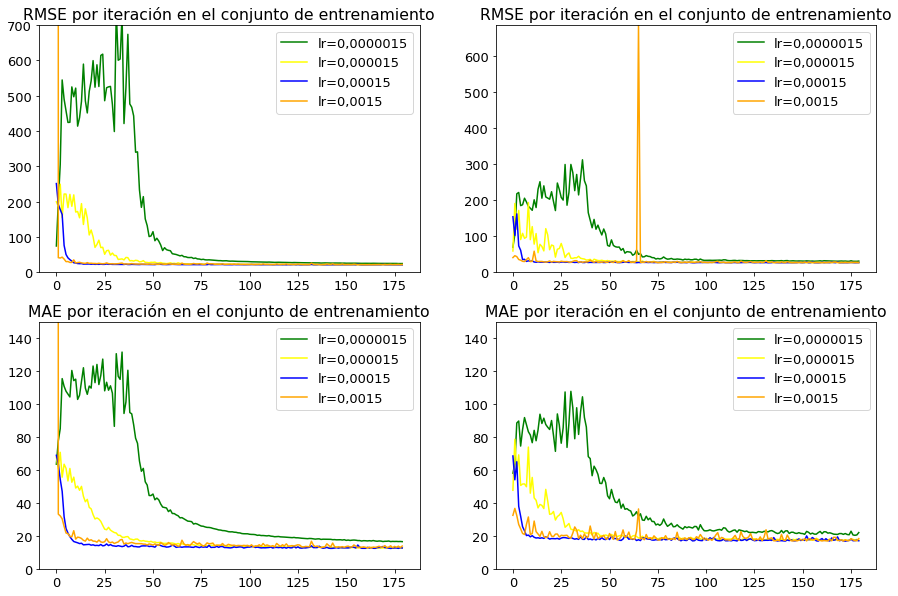

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
#fig.suptitle('RMSE por iteración')
c = ['green','blue','yellow','orange','grey','black']
index = np.arange(num_iter)
ax1.set_title('RMSE por iteración en el conjunto de entrenamiento')
ax1.plot(index, model_adam_0_0000015_train['history']['rmse_by_epoch'], color=c[0], label='lr=0,0000015')
ax1.plot(index, model_adam_0_000015_train['history']['rmse_by_epoch'], color=c[2], label='lr=0,000015')
ax1.plot(index, model_adam_0_00015_train['history']['rmse_by_epoch'], color=c[1], label='lr=0,00015')
ax1.plot(index, model_adam_0_0015_train['history']['rmse_by_epoch'], color=c[3], label='lr=0,0015')
ax1.legend()

y_lim1 = np.max(model_adam_0_0000015_train['history']['rmse_by_epoch'] + \
               model_adam_0_000015_train['history']['rmse_by_epoch'] + \
               model_adam_0_00015_train['history']['rmse_by_epoch'] + \
               model_adam_0_0015_train['history']['rmse_by_epoch'])

ax1.set_ylim([0, min(y_lim1,700)])


ax2.set_title('RMSE por iteración en el conjunto de entrenamiento')
ax2.plot(index, model_adam_0_0000015_train['history']['rmse_val_by_epoch'], color=c[0], label='lr=0,0000015')
ax2.plot(index, model_adam_0_000015_train['history']['rmse_val_by_epoch'], color=c[2], label='lr=0,000015')
ax2.plot(index, model_adam_0_00015_train['history']['rmse_val_by_epoch'], color=c[1], label='lr=0,00015')
ax2.plot(index, model_adam_0_0015_train['history']['rmse_val_by_epoch'], color=c[3], label='lr=0,0015')
ax2.legend()
y_lim2 = np.max(model_adam_0_0000015_train['history']['rmse_val_by_epoch'] + \
               model_adam_0_000015_train['history']['rmse_val_by_epoch'] + \
               model_adam_0_00015_train['history']['rmse_val_by_epoch'] + \
               model_adam_0_0015_train['history']['rmse_val_by_epoch'])

ax2.set_ylim([0, min(y_lim2,700)])



ax3.set_title('MAE por iteración en el conjunto de entrenamiento')
ax3.plot(index, model_adam_0_0000015_train['history']['mae_by_epoch'], color=c[0], label='lr=0,0000015')
ax3.plot(index, model_adam_0_000015_train['history']['mae_by_epoch'], color=c[2], label='lr=0,000015')
ax3.plot(index, model_adam_0_00015_train['history']['mae_by_epoch'], color=c[1], label='lr=0,00015')
ax3.plot(index, model_adam_0_0015_train['history']['mae_by_epoch'], color=c[3], label='lr=0,0015')
ax3.legend()
y_lim3 = np.max(model_adam_0_0000015_train['history']['mae_by_epoch'] + \
               model_adam_0_000015_train['history']['mae_by_epoch'] + \
               model_adam_0_00015_train['history']['mae_by_epoch'] + \
               model_adam_0_0015_train['history']['mae_by_epoch'])

ax3.set_ylim([0, 150])

ax4.set_title('MAE por iteración en el conjunto de entrenamiento')
ax4.plot(index, model_adam_0_0000015_train['history']['mae_val_by_epoch'], color=c[0], label='lr=0,0000015')
ax4.plot(index, model_adam_0_000015_train['history']['mae_val_by_epoch'], color=c[2], label='lr=0,000015')
ax4.plot(index, model_adam_0_00015_train['history']['mae_val_by_epoch'], color=c[1], label='lr=0,00015')
ax4.plot(index, model_adam_0_0015_train['history']['mae_val_by_epoch'], color=c[3], label='lr=0,0015')
ax4.legend()
y_lim4 = np.max(model_adam_0_0000015_train['history']['mae_val_by_epoch'] + \
               model_adam_0_000015_train['history']['mae_val_by_epoch'] + \
               model_adam_0_00015_train['history']['mae_val_by_epoch'] + \
               model_adam_0_0015_train['history']['mae_val_by_epoch'])

ax4.set_ylim([0, 150])
plt.savefig("RMSE_MAE_lr.pdf")

# set labels

# CAPAS OCULTAS

In [21]:
model_adam_L1 = "Model_Adam_L1"
model_adam_L2 = "Model_Adam_L2"
model_adam_L3 = "Model_Adam_L3"
model_adam_L4 = "Model_Adam_L4"
model_adam_L5 = "Model_Adam"
model_adam_L6 = "Model_Adam_L6"

model_adam_L1_train, model_adam_L1_val, model_adam_L1_test =  open_files(model_adam_L1)
model_adam_L2_train, model_adam_L2_val, model_adam_L2_test =  open_files(model_adam_L2)
model_adam_L3_train, model_adam_L3_val, model_adam_L3_test =  open_files(model_adam_L3)
model_adam_L4_train, model_adam_L4_val, model_adam_L4_test =  open_files(model_adam_L4)
model_adam_L5_train, model_adam_L5_val, model_adam_L5_test =  open_files(model_adam_L5)
model_adam_L6_train, model_adam_L6_val, model_adam_L6_test =  open_files(model_adam_L6)

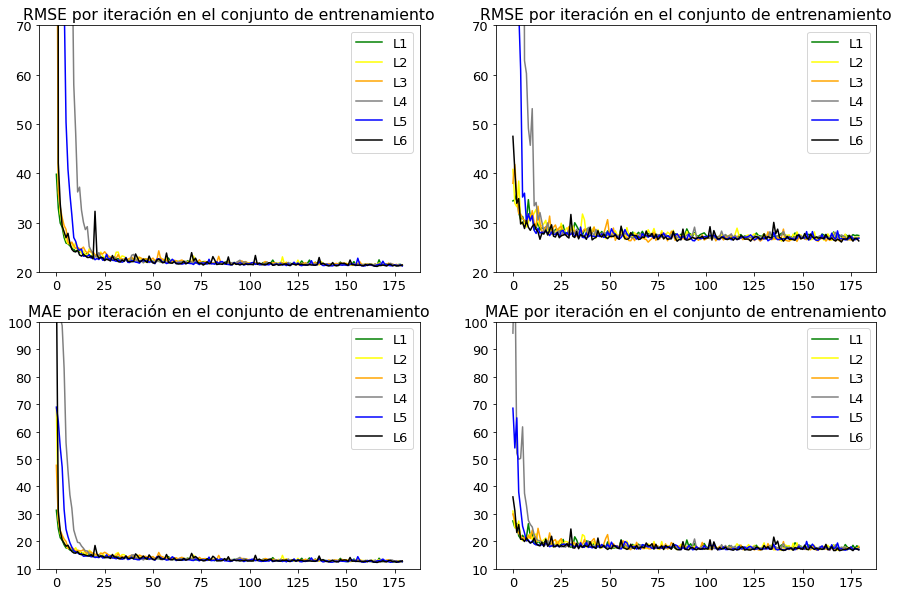

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
#fig.suptitle('RMSE por iteración')
c = ['green','blue','yellow','orange','grey','black']
index = np.arange(180)
ax1.set_title('RMSE por iteración en el conjunto de entrenamiento')
ax1.plot(index, model_adam_L1_train['history']['rmse_by_epoch'], color=c[0], label='L1')
ax1.plot(index, model_adam_L2_train['history']['rmse_by_epoch'], color=c[2], label='L2')
ax1.plot(index, model_adam_L3_train['history']['rmse_by_epoch'], color=c[3], label='L3')
ax1.plot(index, model_adam_L4_train['history']['rmse_by_epoch'], color=c[4], label='L4')
ax1.plot(index, model_adam_L5_train['history']['rmse_by_epoch'], color=c[1], label='L5')
ax1.plot(index, model_adam_L6_train['history']['rmse_by_epoch'], color=c[5], label='L6')
ax1.set_ylim([20, 70])
ax1.legend()

ax2.set_title('RMSE por iteración en el conjunto de entrenamiento')
ax2.plot(index, model_adam_L1_train['history']['rmse_val_by_epoch'], color=c[0], label='L1')
ax2.plot(index, model_adam_L2_train['history']['rmse_val_by_epoch'], color=c[2], label='L2')
ax2.plot(index, model_adam_L3_train['history']['rmse_val_by_epoch'], color=c[3], label='L3')
ax2.plot(index, model_adam_L4_train['history']['rmse_val_by_epoch'], color=c[4], label='L4')
ax2.plot(index, model_adam_L5_train['history']['rmse_val_by_epoch'], color=c[1], label='L5')
ax2.plot(index, model_adam_L6_train['history']['rmse_val_by_epoch'], color=c[5], label='L6')
ax2.set_ylim([20, 70])
ax2.legend()

ax3.set_title('MAE por iteración en el conjunto de entrenamiento')
ax3.plot(index, model_adam_L1_train['history']['mae_by_epoch'], color=c[0], label='L1')
ax3.plot(index, model_adam_L2_train['history']['mae_by_epoch'], color=c[2], label='L2')
ax3.plot(index, model_adam_L3_train['history']['mae_by_epoch'], color=c[3], label='L3')
ax3.plot(index, model_adam_L4_train['history']['mae_by_epoch'], color=c[4], label='L4')
ax3.plot(index, model_adam_L5_train['history']['mae_by_epoch'], color=c[1], label='L5')
ax3.plot(index, model_adam_L6_train['history']['mae_by_epoch'], color=c[5], label='L6')
ax3.set_ylim([10, 100])
ax3.legend()

ax4.set_title('MAE por iteración en el conjunto de entrenamiento')
ax4.plot(index, model_adam_L1_train['history']['mae_val_by_epoch'], color=c[0], label='L1')
ax4.plot(index, model_adam_L2_train['history']['mae_val_by_epoch'], color=c[2], label='L2')
ax4.plot(index, model_adam_L3_train['history']['mae_val_by_epoch'], color=c[3], label='L3')
ax4.plot(index, model_adam_L4_train['history']['mae_val_by_epoch'], color=c[4], label='L4')
ax4.plot(index, model_adam_L5_train['history']['mae_val_by_epoch'], color=c[1], label='L5')
ax4.plot(index, model_adam_L6_train['history']['mae_val_by_epoch'], color=c[5], label='L6')
ax4.set_ylim([10, 100])
ax4.legend()

plt.savefig("RMSE_MAE_layers.pdf")
# set labels

## Resultados Finales

In [23]:
model_adam_train, model_adam_val, model_adam_test =  open_files(model_adam)
num_iter = len(model_adam_train['history']['mae_val_by_epoch'])
index = np.arange(num_iter)

In [24]:
adam_split_train = prediccion_list(model_adam_train)
adam_split_val = prediccion_list(model_adam_val)
adam_split_test = prediccion_list(model_adam_test)

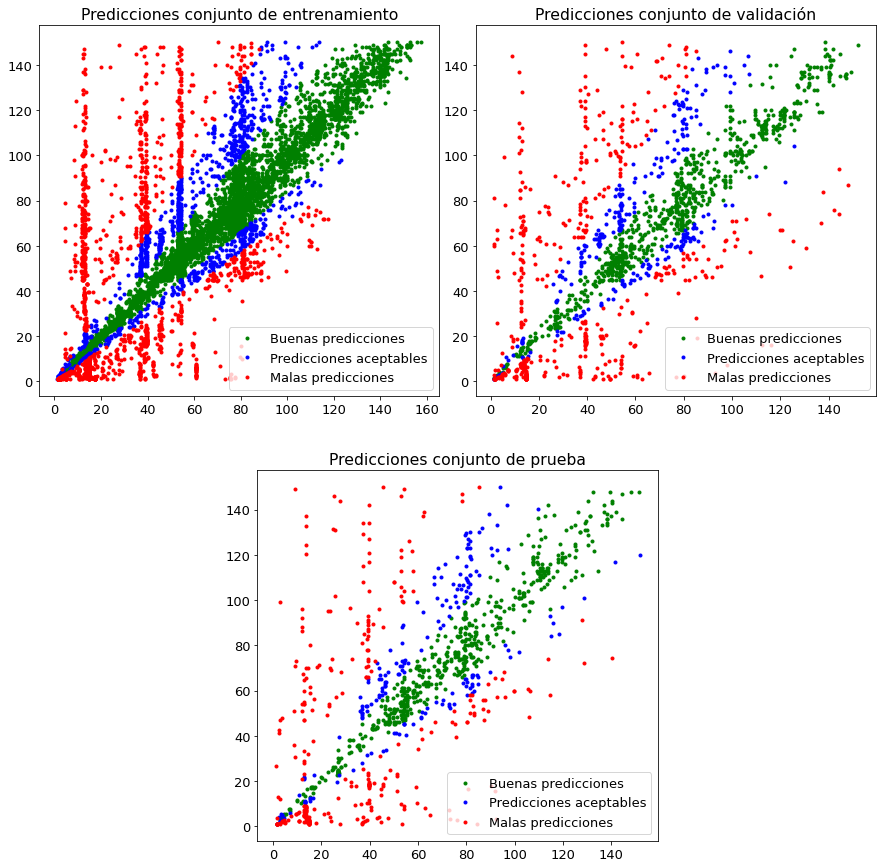

In [25]:
fig = plt.figure(figsize=(15,15))
index = np.arange(num_iter)

ax1 = plt.subplot2grid((2,4),(0,0), colspan=2)
ax1.set_title('Predicciones conjunto de entrenamiento')
ax1.plot(adam_split_train[0],adam_split_train[1], ".", color='green', label = "Buenas predicciones")
ax1.plot(adam_split_train[2],adam_split_train[3], ".", color='blue', label ="Predicciones aceptables")
ax1.plot(adam_split_train[4],adam_split_train[5], ".", color='red', label = "Malas predicciones")
ax1.legend()


ax2 = plt.subplot2grid((2,4),(0,2), colspan=2)
ax2.set_title('Predicciones conjunto de validación')
ax2.plot(adam_split_val[0],adam_split_val[1], ".", color='green', label = "Buenas predicciones")
ax2.plot(adam_split_val[2],adam_split_val[3], ".", color='blue', label ="Predicciones aceptables")
ax2.plot(adam_split_val[4],adam_split_val[5], ".", color='red', label = "Malas predicciones")
ax2.legend()


ax3 = plt.subplot2grid((2,4),(1,1), colspan=2)
ax3.set_title('Predicciones conjunto de prueba')
ax3.plot(adam_split_test[0],adam_split_test[1], ".", color='green', label = "Buenas predicciones")
ax3.plot(adam_split_test[2],adam_split_test[3], ".", color='blue', label ="Predicciones aceptables")
ax3.plot(adam_split_test[4],adam_split_test[5], ".", color='red', label = "Malas predicciones")
ax3.legend()
plt.savefig("predicciones_final.pdf")

In [26]:
model_adam_train, model_adam_val, model_adam_test =  open_files(model_adam)
num_iter = len(model_adam_train['history']['mae_val_by_epoch'])
index = np.arange(num_iter)
tol1, tol2 = 15, 30

adam_split_train = prediccion_list2(model_adam_train,tol1,tol2)
adam_split_val = prediccion_list2(model_adam_val,tol1,tol2)
adam_split_test = prediccion_list2(model_adam_test,tol1,tol2)

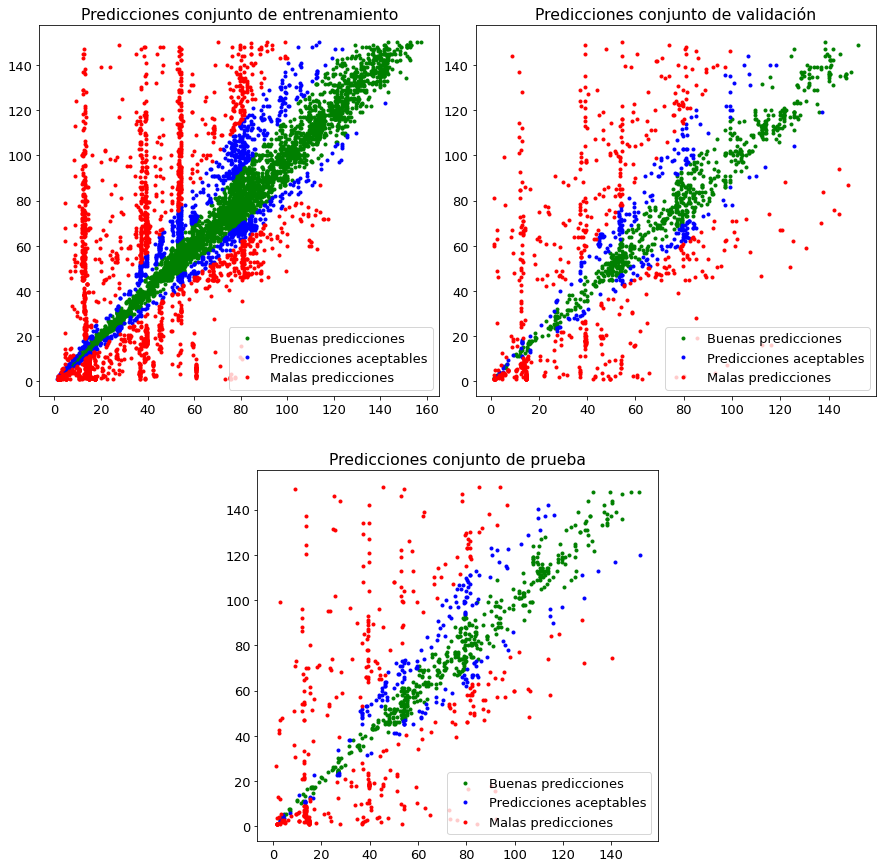

In [27]:
fig = plt.figure(figsize=(15,15))
index = np.arange(num_iter)

ax1 = plt.subplot2grid((2,4),(0,0), colspan=2)
ax1.set_title('Predicciones conjunto de entrenamiento')
ax1.plot(adam_split_train[0],adam_split_train[1], ".", color='green', label = "Buenas predicciones")
ax1.plot(adam_split_train[2],adam_split_train[3], ".", color='blue', label ="Predicciones aceptables")
ax1.plot(adam_split_train[4],adam_split_train[5], ".", color='red', label = "Malas predicciones")
ax1.legend()


ax2 = plt.subplot2grid((2,4),(0,2), colspan=2)
ax2.set_title('Predicciones conjunto de validación')
ax2.plot(adam_split_val[0],adam_split_val[1], ".", color='green', label = "Buenas predicciones")
ax2.plot(adam_split_val[2],adam_split_val[3], ".", color='blue', label ="Predicciones aceptables")
ax2.plot(adam_split_val[4],adam_split_val[5], ".", color='red', label = "Malas predicciones")
ax2.legend()


ax3 = plt.subplot2grid((2,4),(1,1), colspan=2)
ax3.set_title('Predicciones conjunto de prueba')
ax3.plot(adam_split_test[0],adam_split_test[1], ".", color='green', label = "Buenas predicciones")
ax3.plot(adam_split_test[2],adam_split_test[3], ".", color='blue', label ="Predicciones aceptables")
ax3.plot(adam_split_test[4],adam_split_test[5], ".", color='red', label = "Malas predicciones")
ax3.legend()
plt.savefig("predicciones_final2.pdf")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
#fig.suptitle('RMSE por iteración')

index = np.arange(num_iter)

ax1.set_title('RMSE por iteración')
ax1.plot(index, model_adam_train['history']['rmse_by_epoch'], color='blue', label = "Conjunto de entrenamiento")
ax1.plot(index, model_adam_train['history']['rmse_val_by_epoch'], color='orange', label = "Conjunto de validación")
ax1.set_ylim([0, 120])
ax1.legend()

ax2.set_title('MAE por iteración')
ax2.plot(index, model_adam_train['history']['mae_by_epoch'], color='blue', label = "Conjunto de entrenamiento")
ax2.plot(index, model_adam_train['history']['mae_val_by_epoch'], color='orange', label = "Conjunto de validación")
ax2.legend()

plt.savefig("RMSE_MAE_final.pdf")
# set labels